In [2]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import jax
import sys
from scipy.stats import mannwhitneyu, ks_2samp
from tqdm import tqdm
import preliz as pz

sys.path.append("../models/")
from orton_2009 import *
# Rap1 models
from shin_2014_Rap1 import *
from ryu_2015_Rap1 import *
from vonKriegsheim_2009_Rap1 import *

jax.config.update("jax_enable_x64", True)

sys.path.insert(0, '../')
from utils import *

rng = np.random.default_rng(seed=1234)

# directories
datadir = '../../../results/MAPK/param_est/Keyes_2020_data_locDiffs/'
savedir = '../../../results/MAPK/param_est/Keyes_2020_data_locDiffs/'


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Load data and set up the colors

In [3]:
# load in the model info 
orton_cases_df = pd.read_csv('../param_est/orton_2009_loc_diff_models_params.csv', delimiter='.',
                            names=['case', 'diff_params'])
shin_cases_df = pd.read_csv('../param_est/shin_2014_loc_diff_models_params.csv', delimiter='.',
                            names=['case', 'diff_params'])
ryu_cases_df = pd.read_csv('../param_est/ryu_2015_loc_diff_models_params.csv', delimiter='.',
                            names=['case', 'diff_params'])

model_names = {'orton_2009':list(orton_cases_df['case'].values),
               'shin_2014':list(shin_cases_df['case'].values),
               'ryu_2015':list(ryu_cases_df['case'].values),}

m_names = [model + '_' + submodel for model in model_names.keys() for submodel in model_names[model]]

# load in the training data
data_file = '../../../results/MAPK/Keyes_et_al_2020-fig1-data1-v2-'

inputs_CYTO, data_CYTO, data_std_CYTO, times_CYTO \
    = load_data_json(data_file+'CYTO_CYTOmax.json', data_std=True, time=True)
inputs_PM, data_PM, data_std_PM, times_PM \
    = load_data_json(data_file+'PM_PMmax.json', data_std=True, time=True)

data_file = '../../../results/MAPK/Keyes_et_al_2020-fig3-data1-v2-'
inputs_CYTO_RAP1i, data_CYTO_RAP1i, data_std_CYTO_RAP1i, \
    times_CYTO_RAP1i = load_data_json(data_file+'CYTO_RAP1inhib_CYTOmax.json', \
    data_std=True, time=True)
inputs_PM_RAP1i, data_PM_RAP1i, data_std_PM_RAP1i, times_PM_RAP1i \
    = load_data_json(data_file+'PM_RAP1inhib_PMmax.json', \
    data_std=True, time=True)

data_time_to_mins = 60

# data in each compartment are sampled at slightly different times, so we need to interpolate to align them
# use diffrax linear interpolation to get the MAPK activity at specific time point over 40mins
data_CYTO_interp = diffrax.LinearInterpolation(times_CYTO, data_CYTO)
data_std_CYTO_interp = diffrax.LinearInterpolation(times_CYTO, data_std_CYTO)
data_PM_interp = diffrax.LinearInterpolation(times_PM, data_PM)
data_std_PM_interp = diffrax.LinearInterpolation(times_PM, data_std_PM)

data_CYTO_RAP1i_interp = diffrax.LinearInterpolation(times_CYTO_RAP1i, \
    data_CYTO_RAP1i)
data_std_CYTO_RAP1i_interp = diffrax.LinearInterpolation(times_CYTO_RAP1i,\
    data_std_CYTO_RAP1i)
data_PM_RAP1i_interp = diffrax.LinearInterpolation(times_PM_RAP1i, data_PM_RAP1i)
data_std_PM_RAP1i_interp = diffrax.LinearInterpolation(times_PM_RAP1i, \
    data_std_PM_RAP1i)

min_time = np.round(np.min([times_CYTO[-1], times_PM[-1], times_CYTO_RAP1i[-1], times_PM_RAP1i[-1]]))
n_times = np.max([len(times_CYTO), len(times_PM), len(times_CYTO_RAP1i), len(times_PM_RAP1i)])
times = np.linspace(0, min_time, n_times)

# get data at standard times
data = {
    'CYTO':data_CYTO_interp.evaluate(times),
    'PM':data_PM_interp.evaluate(times),
    'CYTO_Rap1KD':data_CYTO_RAP1i_interp.evaluate(times),
    'PM_Rap1KD':data_PM_RAP1i_interp.evaluate(times)}

data_std = {
    'CYTO':data_std_CYTO_interp.evaluate(times),
    'PM':data_std_PM_interp.evaluate(times),
    'CYTO_Rap1KD':data_std_CYTO_RAP1i_interp.evaluate(times),
    'PM_Rap1KD':data_std_PM_RAP1i_interp.evaluate(times)}

# set up colors
colors = get_color_pallette(n_colors=len(m_names))
color_dict = {m_names[i]:colors[i] for i in range(len(m_names))}

Load all model info

In [15]:
# storage dictionaries
idata = {}
ss = {}

for idx, model in enumerate(model_names.keys()):
    for submodel in model_names[model]:
        # if 'Rap1_negFB_Ras-GTP-deact_Raf-deact_ppMEK-dephos_ppERK-dephos' not in submodel:
        name = datadir + model + '/' + submodel + '/'
        if model in ['shin_2014', 'ryu_2015']:
            model_ = model + '_Rap1'
        else:
            model_ = model
        key = model + '_' + submodel

        # load in the posterior idata
        idata[key], ss[key], t_samp = load_smc_samples_to_idata(name + submodel + model_ + '_smc_samples.json', sample_time=True)

        if len(ss[key]['log_marginal_likelihood']) == 1:
            ss[key]['log_marginal_likelihood'] = ss[key]['log_marginal_likelihood'][0]

        # print sample time
        print(key, t_samp)

orton_2009_Rap1 2390.9462621212006
orton_2009_negFB 2085.7226998806
orton_2009_ppMEK-ERK 6728.9078159332275
orton_2009_ppERK-pASE 1978.5914108753204
orton_2009_Rap1_negFB 2356.2352950572968
orton_2009_Rap1_ppMEK-ERK 2691.2541229724884
orton_2009_Rap1_ppERK-pASE 2268.089385032654
orton_2009_negFB_ppMEK-ERK 2114.516932964325
orton_2009_negFB_ppERK-pASE 2337.517387866974
orton_2009_ppMEK-ERK_ppERK-pASE 2380.713443040848
orton_2009_Rap1_negFB_ppMEK-ERK 2851.787470817566
orton_2009_Rap1_negFB_ppERK-pASE 2397.5038878917694
orton_2009_Rap1_ppMEK-ERK_ppERK-pASE 2613.88064289093
orton_2009_negFB_ppMEK-ERK_ppERK-pASE 2525.2897918224335
orton_2009_all 2492.5211539268494
shin_2014_Rap1 739.1163718700409
shin_2014_negFB 590.2669749259949
shin_2014_Ras-GTP-deact 626.7307810783386
shin_2014_Raf-deact 669.340980052948
shin_2014_ppMEK-dephos 576.1122581958771
shin_2014_ppERK-dephos 579.5083000659943
shin_2014_Rap1_negFB 693.8933379650116
shin_2014_Rap1_Ras-GTP-deact 690.2221839427948
shin_2014_Rap1_Raf

Now compute LOO-CV, and stacking weights for all models together

In [9]:
idata_modified = {}
for key in idata.keys():
    log_like = idata[key].log_likelihood
    llike = np.concatenate((log_like['llike_CYTO'].values, log_like['llike_PM'].values, log_like['llike_CYTO_Rap1KD'].values, log_like['llike_PM_Rap1KD'].values), axis=3)
    coords = {'chains':np.arange(4), 'draws':np.arange(500), 'llike_dim_0':np.arange(1), 'llike_dim_1':np.arange(llike.shape[3])}
    temp = az.from_dict(log_likelihood={'llike':llike}, 
                        coords=coords)
    temp.add_groups({'posterior':idata[key].posterior,
                     'observed_data':idata[key].observed_data,
                     'constant_data':idata[key].constant_data})
    idata_modified[key] = temp

Now compute everything that we need to MMI

In [10]:
# first pseudo BMA and stacking
compare_data_loo_pbma = az.compare(idata_modified, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_stack = az.compare(idata_modified, ic='loo', method='stacking', seed=rng)

/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/natetest/miniforge3

Now model probabilities

In [11]:
log_marginal_likes = {}
for model in ss.keys():
    tmp = ss[model]['log_marginal_likelihood']
    tmp = [lst[-1] for lst in tmp]
    log_marginal_likes[model] = np.mean(tmp)

# compute model probabilities
# function to compute log sum exponential in a numerically stable way
def logsumexp(x):
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

model_probs = {}
n_models = len(log_marginal_likes.keys())
prior_prob = 1/n_models
log_marg_likes = np.array(list(log_marginal_likes.values()))
m_prob = weight_with_logsumexp(np.log(prior_prob)+log_marg_likes)
model_probs = {key:m_prob[i] for i, key in enumerate(log_marginal_likes.keys())}

model_prob_df = pd.DataFrame.from_dict(model_probs, orient='index', columns=['model probability'])

Plot ELPD estimates, model probs and weights

In [12]:
compare_data_loo_pbma_selected = compare_data_loo_pbma[['elpd_loo', 'weight']].rename(columns={'weight': 'pbma weight'})
compare_data_loo_stack_selected = compare_data_loo_stack[['elpd_loo', 'weight']].rename(columns={'weight': 'stack weight'})
combined_df = compare_data_loo_pbma_selected.join(compare_data_loo_stack_selected['stack weight']).join(model_prob_df)

def mod_name(str):
    tmp = str.split('_')
    tmp[0] = tmp[0][0].upper() + "'"
    tmp[1] = tmp[1] + ':'
    tmp = ' '.join(tmp)
    
    return tmp

combined_df.index = combined_df.index.map(mod_name)
print(combined_df)

combined_df.to_csv(savedir + 'model_comparison.csv')

                                       elpd_loo   pbma weight  stack weight  \
O' 2009: Rap1 ppMEK-ERK ppERK-pASE   343.585097  4.042119e-01  8.820377e-01   
O' 2009: all                         343.406123  3.369339e-01  9.525520e-09   
O' 2009: Rap1 negFB ppERK-pASE       341.455855  7.185797e-02  5.214772e-09   
O' 2009: Rap1 ppERK-pASE             341.370714  8.032651e-02  5.206648e-09   
R' 2015: Rap1 negFB                  339.736925  6.511923e-02  5.448044e-02   
...                                         ...           ...           ...   
R' 2015: ppMEK-ERK                   208.881527  1.087483e-50  2.261937e-10   
R' 2015: negFB ppMEK-ERK             201.587589  1.747994e-50  1.269816e-09   
R' 2015: negFB ppMEK-ERK ppERK-pASE  201.079583  5.851364e-54  5.052320e-10   
R' 2015: Rap1 ppMEK-ERK ppERK-pASE   175.418819  3.789958e-62  3.336661e-11   
R' 2015: ppMEK-ERK ppERK-pASE        172.626045  6.639028e-59  0.000000e+00   

                                     model probabil

Now plot marginals of the top models

In [8]:
combined_df = combined_df.reset_index()
threshold = 0.01
top_models = combined_df[(combined_df['pbma weight'] > threshold) | 
                         (combined_df['stack weight'] > threshold) | 
                         (combined_df['model probability'] > threshold)]['index'].tolist()

def undo_mod_name(str):
    tmp = str.split(' ')
    names = {"O'":'orton_2009', "S'":'shin_2014', "R'":'ryu_2015'}
    tmp[0] = names[tmp[0]]
    tmp.pop(1)
    tmp = '_'.join(tmp)
    
    return tmp

top_model_names = top_models.copy()
top_models = [undo_mod_name(model) for model in top_models]

top_models

['orton_2009_Rap1_ppMEK-ERK_ppERK-pASE',
 'orton_2009_all',
 'orton_2009_Rap1_negFB_ppERK-pASE',
 'orton_2009_Rap1_ppERK-pASE',
 'ryu_2015_Rap1_negFB',
 'ryu_2015_Rap1_negFB_ppERK-pASE']

In [11]:
combined_df

,index,elpd_loo,pbma weight,stack weight,model probability
0,O' 2009: Rap1 ppMEK-ERK ppERK-pASE,343.585097,4.042119e-01,8.820377e-01,3.432727e-01
1,O' 2009: all,343.406123,3.369339e-01,9.525520e-09,9.296608e-02
2,O' 2009: Rap1 negFB ppERK-pASE,341.455855,7.185797e-02,5.214772e-09,1.600491e-01
3,O' 2009: Rap1 ppERK-pASE,341.370714,8.032651e-02,5.206648e-09,4.022960e-01
4,R' 2015: Rap1 negFB,339.736925,6.511923e-02,5.448044e-02,1.061014e-09
...,...,...,...,...,...
89,R' 2015: ppMEK-ERK,208.881527,1.087483e-50,2.261937e-10,2.027218e-49
90,R' 2015: negFB ppMEK-ERK,201.587589,1.747994e-50,1.269816e-09,5.272191e-51
91,R' 2015: negFB ppMEK-ERK ppERK-pASE,201.079583,5.851364e-54,5.052320e-10,1.003491e-54
92,R' 2015: Rap1 ppMEK-ERK ppERK-pASE,175.418819,3.789958e-62,3.336661e-11,2.080442e-60


In [9]:
# now plot 1D marginal posterior distributions for the parameters that vary in the top models
xlims = {
    'k1_C3G_Deactivation': (0.9, 40), 
    'km_Erk_Deactivation': (20000000., 200000000.), 
    'km_Erk_Activation': (10595626.664458357, 271055048.0731411), 
    'K2': (4.25, 5.75), 
    'D2': (9.201389955116981e-05, 0.004828965134976862), 
    'dusp_ind': (0.06444894174954023, 607.807832496739), 
    'K_dusp': (0.0007685846739108812, 15.544058926857462), 
    'T_dusp': (1.7501451111844935, 485.09753905531466), 
    'k_RafRap1': (0.319428256171953, 2820251.9589669877), 
    'D_RafRap1': (5.683855376490856e-07, 47294.623074303556), 
    'k1_Sos_Deactivation': (0.0005, 5.), 
    'k1_P90Rsk_Deactivation': (1.e-06, 10.)}

display_names = {
    'k1_C3G_Deactivation': r'$k_{C3G,deact}$', 
    'km_Erk_Deactivation': r'$K_{m,ERK,deact}$', 
    'km_Erk_Activation': r'$K_{m,ERK,act}$',
    'K2': r'$K2$', 
    'D2': r'$D2$', 
    'dusp_ind': r'$dusp_{ind}$', 
    'K_dusp': r'$K_{dusp}$', 
    'T_dusp': r'$T_{dusp}$', 
    'k_RafRap1': r'$k_{Raf,Rap1}$', 
    'D_RafRap1': r'$K_{m,Raf,Rap1}$', 
    'k1_Sos_Deactivation': r'$k_{Sos,deact}$', 
    'k1_P90Rsk_Deactivation': r'$k_{P90Rsk,deact}$'}

for model in top_models:
    post_data = idata[model].posterior.data_vars
    items = list(post_data.keys())
    items = [item for item in items if 'prediction' not in item]
    items = [item for item in items if '_CYTO' in item]
    vary_params = [item.split('_CYTO')[0] for item in items]

    items = list(post_data.keys())
    items = [item for item in items if 'CYTO' not in item]
    not_vary_params = [item for item in items if 'PM' not in item]

    for param in vary_params+not_vary_params:

        fig, ax = get_sized_fig_ax(0.5,0.5)

        if param != 'K2':
                x_logscale=True
        else:
            x_logscale=False
        
        if param in vary_params:
            cyto = np.array(idata[model].posterior[param + '_CYTO'].stack(sample=['chain', 'draw']))
            pm = np.array(idata[model].posterior[param + '_PM'].stack(sample=['chain', 'draw']))
            
            # plot eCDFs of CYTO and PM
            dat = pd.DataFrame({'CYTO':cyto, 'PM':pm})
            # sns.ecdfplot(dat, ax=ax, 
            #             palette=['blue', 'black'], 
            #             legend=False, linewidth=1.5)
            sns.kdeplot(dat, ax=ax, 
                        palette=['blue', 'black'], 
                        legend=False, linewidth=1.5, log_scale=(x_logscale, False), fill=True)
        
        else:
            dat = np.array(idata[model].posterior[param].stack(sample=['chain', 'draw']))
            sns.kdeplot(dat, ax=ax, color='red', legend=False, 
                        linewidth=1.5, log_scale=(x_logscale, False), fill=True)
        
        # plot setup
        ax.tick_params(axis='both', which='major', labelsize=8.0, pad=1.25)
        ax.set_ylabel('', fontsize=10.0)

        ax.set_xlim(xlims[param])
        ax.set_xlabel(display_names[param], fontsize=8.0, labelpad=-0.75) 

        fig.savefig(savedir + 'top_model_marginals/' + model + '_' + param + '.pdf', 
                    bbox_inches='tight', transparent=True)

        plt.close()


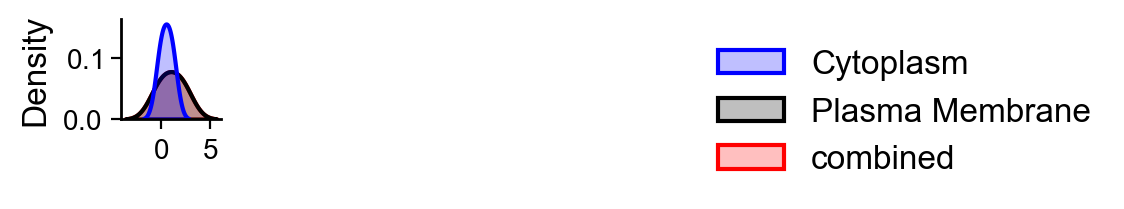

In [10]:
# legend
dat = pd.DataFrame({
    'Cytoplasm':np.array([0, 1]),
    'Plasma Membrane':np.array([0, 2]),
    'combined':np.array([0, 2])
})

fig, ax = get_sized_fig_ax(0.5,0.5)
ax = sns.kdeplot(dat, ax=ax, palette=['blue', 'black', 'red'], linewidth=1.5, fill=True)

leg = ax.get_legend()
leg.set_bbox_to_anchor((10.0, 1.0))
leg.set_ncols(3)


export_legend(leg, filename=savedir + 'top_model_marginals/legend.pdf')

# leg = ax.legend(ncol=3, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=10.0)


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_38867/1147508563.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_38867/1147508563.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=90, fontsize=10.0)


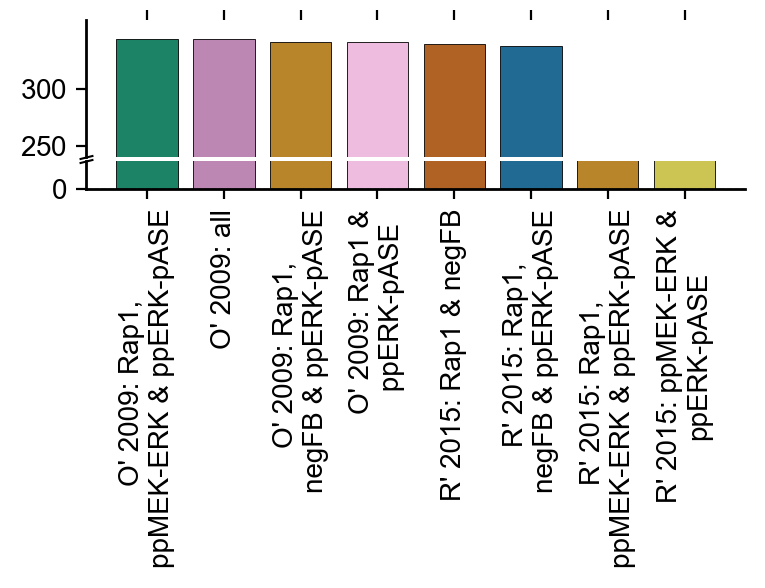

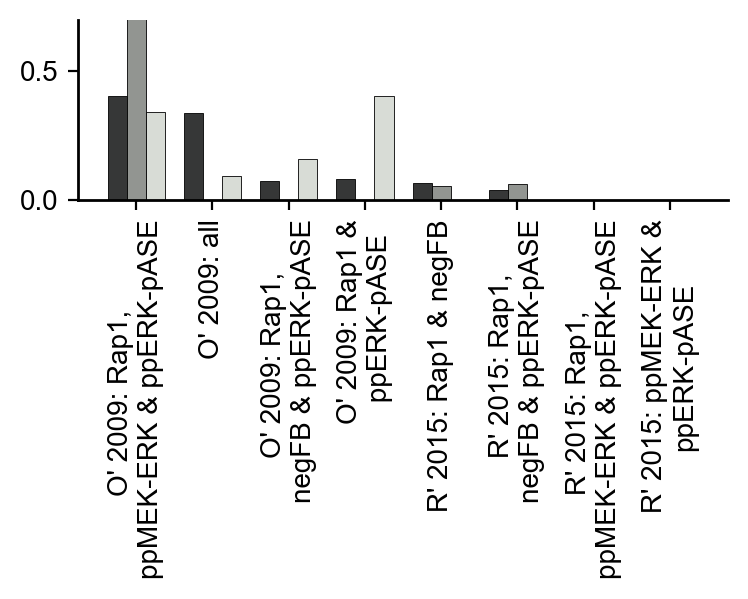

In [22]:
worst_models= ["ryu_2015_Rap1_ppMEK-ERK_ppERK-pASE", "ryu_2015_ppMEK-ERK_ppERK-pASE"]
_colors = [color_dict[model] for model in top_models+worst_models]

# ['orton_2009_Rap1_ppMEK-ERK_ppERK-pASE',
#  'orton_2009_all',
#  'orton_2009_Rap1_negFB_ppERK-pASE',
#  'orton_2009_Rap1_ppERK-pASE',
#  'ryu_2015_Rap1_negFB',
#  'ryu_2015_Rap1_negFB_ppERK-pASE']

names=[
    "O' 2009: Rap1, \nppMEK-ERK & ppERK-pASE",
    "O' 2009: all",
    "O' 2009: Rap1, \nnegFB & ppERK-pASE",
    "O' 2009: Rap1 &\n ppERK-pASE",
    "R' 2015: Rap1 & negFB",
    "R' 2015: Rap1, \nnegFB & ppERK-pASE",
    "R' 2015: Rap1, \nppMEK-ERK & ppERK-pASE",
    "R' 2015: ppMEK-ERK &\nppERK-pASE"
]


# ELPD
dat = [compare_data_loo_pbma['elpd_loo'][model] for model in top_models+worst_models]
# fig, ax = get_sized_fig_ax(3.25, 0.9)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.25, 1.1), sharex=True,
                               height_ratios=[5, 1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

for ax in [ax1, ax2]:
    bar = ax.bar(top_models+worst_models, dat, edgecolor='k')
    ax.set_xticklabels(names, rotation=90, fontsize=10.0)
    for i, br in enumerate(bar):
        br.set_facecolor(_colors[i])
    xlim = ax.get_xlim()
    ax.plot(xlim, [0,0], '--k', linewidth=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim([0.25*np.min(dat), np.max(dat)])

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(240, 1.05*np.max(dat))  # outliers only
ax2.set_ylim(0, 15)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
# ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the Axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the Axes size or scale
# Finally, we need to disable clipping.

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=0.75, clip_on=False)
ax1.plot([0], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)

ax1.set_yticks([250, 300])
ax2.set_yticks([0])

fig.savefig(savedir + 'model_elpds.pdf', transparent=True)


# model weights
x = np.arange(len(top_models+worst_models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack['weight'][model] for model in top_models+worst_models]
pBMA = [compare_data_loo_pbma['weight'][model] for model in top_models+worst_models]
bma = [model_probs[model] for model in top_models+worst_models]

fig, ax = get_sized_fig_ax(3.25, 0.9)
for dat, name, col in zip([pBMA, stack, bma], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k')
    # ax.bar_label(bar, padding=3)
    multiplier += 1

# ax.set_ylabel('model weight', fontsize=12)
ax.set_xticks(x + width, names)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
leg = ax.legend(loc='center', fontsize=10.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
leg.remove()

# ax.set_ylabel(r'weight', fontsize=12)
ax.set_xticklabels(names, rotation=90, fontsize=10.0)
ax.set_ylim([0, 0.70])
fig.savefig(savedir  + 'model_weights.pdf', transparent=True)

### Redo the analysis w/ only the negFB and Rap1 models

Now repeat without the all diff models

In [ ]:
log_marginal_likes

dict_keys(['orton_2009_Rap1', 'orton_2009_negFB', 'orton_2009_ppMEK-ERK', 'orton_2009_ppERK-pASE', 'orton_2009_Rap1_negFB', 'orton_2009_Rap1_ppMEK-ERK', 'orton_2009_Rap1_ppERK-pASE', 'orton_2009_negFB_ppMEK-ERK', 'orton_2009_negFB_ppERK-pASE', 'orton_2009_ppMEK-ERK_ppERK-pASE', 'orton_2009_Rap1_negFB_ppMEK-ERK', 'orton_2009_Rap1_negFB_ppERK-pASE', 'orton_2009_Rap1_ppMEK-ERK_ppERK-pASE', 'orton_2009_negFB_ppMEK-ERK_ppERK-pASE', 'orton_2009_all', 'shin_2014_Rap1', 'shin_2014_negFB', 'shin_2014_Ras-GTP-deact', 'shin_2014_Raf-deact', 'shin_2014_ppMEK-dephos', 'shin_2014_ppERK-dephos', 'shin_2014_Rap1_negFB', 'shin_2014_Rap1_Ras-GTP-deact', 'shin_2014_Rap1_Raf-deact', 'shin_2014_Rap1_ppMEK-dephos', 'shin_2014_Rap1_ppERK-dephos', 'shin_2014_negFB_Ras-GTP-deact', 'shin_2014_negFB_Raf-deact', 'shin_2014_negFB_ppMEK-dephos', 'shin_2014_negFB_ppERK-dephos', 'shin_2014_Ras-GTP-deact_Raf-deact', 'shin_2014_Ras-GTP-deact_ppMEK-dephos', 'shin_2014_Ras-GTP-deact_ppERK-dephos', 'shin_2014_Raf-deact_pp

In [ ]:
model_subset = [
    'orton_2009_Rap1',
    'shin_2014_Rap1',
    'ryu_2015_Rap1',
    'orton_2009_negFB',
    'shin_2014_negFB',
    'ryu_2015_negFB',
     'orton_2009_Rap1_negFB',
     'shin_2014_Rap1_negFB',
     'ryu_2015_Rap1_negFB'
]

model_subset_names = [
    "O' 2009",
    "S' 2014",
    "R' 2015",
    "O' 2009",
    "S' 2014",
    "R' 2015",
    "O' 2009",
    "S' 2014",
    "R' 2015"
]

# model_subset_names = [
#     "O' 2009: Rap1 diff.",
#     "S' 2014: Rap1 diff.",
#     "R' 2015: Rap1 diff.",
#     "O' 2009: negFB diff.",
#     "S' 2014: negFB diff.",
#     "R' 2015: negFB diff.",
#     "O' 2009: Rap1 & negFB diff.",
#     "S' 2014: Rap1 & negFB diff.",
#     "R' 2015: Rap1 & negFB diff."
# ]

idata_subset = {}
log_marginal_likes_subset = {}
for model in model_subset:
    idata_subset[model] = idata_modified[model]
    log_marginal_likes_subset[model] = log_marginal_likes[model]
print(idata.keys())

compare_data_loo_pbma = az.compare(idata_subset, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_stack = az.compare(idata_subset, ic='loo', method='stacking', seed=rng)


model_probs_subset = {}
n_models = len(log_marginal_likes_subset.keys())
prior_prob = 1/n_models
log_marg_likes = np.array(list(log_marginal_likes_subset.values()))
m_prob = weight_with_logsumexp(np.log(prior_prob)+log_marg_likes)
model_probs_subset = {key:m_prob[i] for i, key in enumerate(log_marginal_likes_subset.keys())}

In [4]:
_colors = [color_dict[model] for model in model_subset]

print(_colors)

# ELPD
dat = [compare_data_loo_pbma['elpd_loo'][model] for model in model_subset]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_subset, dat, edgecolor='k', alpha=0.85)
ax.set_xticklabels(model_subset_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(_colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0.25*np.min(dat), np.max(dat)])
ax.set_yticks([0, 200.0])
ax.set_yticklabels([0, 200.0], fontsize=10.0)
fig.savefig(savedir + 'rap1negFB_subset_elpd_loo.pdf', transparent=True)

# Model probs
dat = [model_probs_subset[model] for model in model_subset]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_subset, dat, edgecolor='k', alpha=0.85)
ax.set_xticklabels(model_subset_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(_colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=10.0)
fig.savefig(savedir + 'rap1negFB_subset_model_probs.pdf', transparent=True)

# model weights
x = np.arange(9)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack['weight'][model] for model in model_subset]
pBMA = [compare_data_loo_pbma['weight'][model] for model in model_subset]
bma = [model_probs_subset[model] for model in model_subset]

print(bma)
fig, ax = get_sized_fig_ax(2.5, 0.9)
for dat, name, col in zip([pBMA, stack, bma], ['pBMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k', alpha=0.85)
    # ax.bar_label(bar, padding=3)
    multiplier += 1

ax.set_ylabel('model weight', fontsize=12)
ax.set_xticks(x + width, model_subset_names)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
leg = ax.legend(loc='center', fontsize=8.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
leg.remove()

ax.set_ylabel(r'weight', fontsize=12)
ax.set_xticklabels(model_subset_names, rotation=90, fontsize=10.0)
ax.set_ylim([0, 1.0])
fig.savefig(savedir  + 'rap1negFB_subset_model_weights.pdf', transparent=True)

[(0.12539215686274507, 0.4159803921568628, 0.5765686274509804), (0.7200980392156862, 0.5748039215686274, 0.4524509803921568), (0.43813725490196087, 0.6777450980392156, 0.8128431372549019), (0.7216666666666667, 0.5202941176470588, 0.16852941176470593), (0.9321568627450979, 0.7384313725490196, 0.8735294117647059), (0.12539215686274507, 0.4159803921568628, 0.5765686274509804), (0.7423529411764707, 0.5282352941176469, 0.7015686274509803), (0.7216666666666667, 0.5202941176470588, 0.16852941176470593), (0.6891176470588235, 0.3857843137254902, 0.14617647058823535)]


#### Plot PDF of Rap1 and (-)feedback parameters in the Rap1 & (-)feedback models

Stats for orton_2009_Rap1_negFB, parameter k1_C3G_Deactivation
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)
Stats for orton_2009_Rap1_negFB, parameter k1_P90Rsk_Deactivation
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)
Stats for orton_2009_Rap1_negFB, parameter k1_Sos_Deactivation
Mann-Whitney p<0.05: True (p=2.449479e-33 )
 KS:True (p=1.763820e-30)
Stats for ryu_2015_Rap1_negFB, parameter k_RafRap1
Mann-Whitney p<0.05: True (p=1.098862e-05 )
 KS:True (p=2.050842e-06)
Stats for ryu_2015_Rap1_negFB, parameter D_RafRap1
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)
Stats for ryu_2015_Rap1_negFB, parameter dusp_ind
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)
Stats for ryu_2015_Rap1_negFB, parameter K_dusp
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)
Stats for ryu_2015_Rap1_negFB, parameter T_dusp
Mann-Whitney p<0.05: True (p=0.000000e+00 )
 KS:True (p=0.000000e+00)


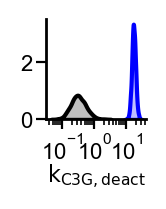

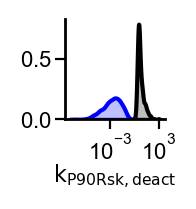

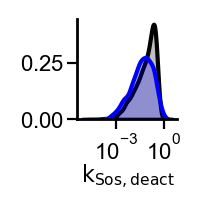

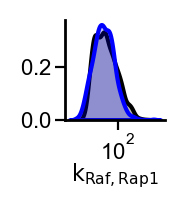

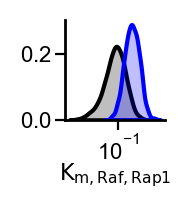

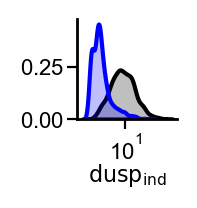

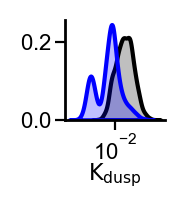

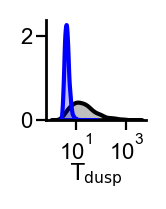

In [25]:
params = {'orton_2009_Rap1_negFB':['k1_C3G_Deactivation', 'k1_P90Rsk_Deactivation', 'k1_Sos_Deactivation'],
          'ryu_2015_Rap1_negFB':['k_RafRap1','D_RafRap1','dusp_ind','K_dusp','T_dusp']}

for model in params.keys():
    for param in params[model]:
            fig, ax = get_sized_fig_ax(0.5,0.5)

            cyto = np.array(idata[model].posterior[param + '_CYTO'].stack(sample=['chain', 'draw']))
            pm = np.array(idata[model].posterior[param + '_PM'].stack(sample=['chain', 'draw']))
            
            # plot eCDFs of CYTO and PM
            dat = pd.DataFrame({'CYTO':cyto, 'PM':pm})
            # sns.ecdfplot(dat, ax=ax, 
                        # palette=['blue', 'black'], 
                        # legend=False, linewidth=1.5)
            sns.kdeplot(dat, ax=ax, 
                        palette=['blue', 'black'], 
                        legend=False, linewidth=1.5, log_scale=(True, False), fill=True)
            # xlim = ax.get_xlim()
            # ax.set_xlim(xlims[param])
            
            # plot setup
            ax.tick_params(axis='both', which='major', labelsize=8.0, pad=1.25)
            ax.set_ylabel('', fontsize=10.0)
            ax.set_xlabel(display_names[param], fontsize=8.0, labelpad=-0.75)    

            # save the figure
            fig.savefig(savedir + 'rap1_negFB_marginals/' + model + '_' + param + '_cyto_vs_pm.pdf', transparent=True, bbox_inches='tight')

            # compute stats and print
            mwu = mannwhitneyu(cyto, pm, alternative='two-sided')
            ks = ks_2samp(cyto, pm, alternative='two-sided')
            text = 'Mann-Whitney p<0.05: {mw} (p={pmw:.6e} )\n KS:{ks} (p={pks:.6e})'.format(mw=mwu.pvalue<0.05, ks=ks.pvalue<0.05, pmw=mwu.pvalue, pks=ks.pvalue)
            print('Stats for {mod}, parameter {param}'.format(mod=model, param=param) + '\n' + text)

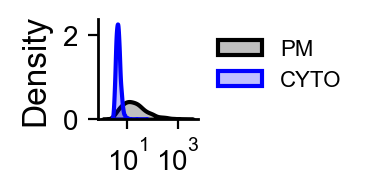

In [26]:
fig, ax = get_sized_fig_ax(0.5,0.5)
dat = pd.DataFrame({'CYTO':cyto, 'PM':pm})
            # sns.ecdfplot(dat, ax=ax, 
                        # palette=['blue', 'black'], 
                        # legend=False, linewidth=1.5)
sns.kdeplot(dat, ax=ax, 
    palette=['blue', 'black'], 
    legend=False, linewidth=1.5, log_scale=(True, False), fill=True)

leg = ax.legend(['PM', 'CYTO'], loc='upper left', fontsize=8.0, bbox_to_anchor=(1.0, 1.0), ncol=1)
export_legend(leg, filename=savedir + 'displot_legend.pdf')